![Brockmann Consult](https://www.brockmann-consult.de/wp-content/uploads/2018/04/brockmann_logo_kontur.png)
<img src="https://www.earthsystemdatalab.net/wp-content/uploads/2018/05/cube_text_logo_v3.png" alt="image" width="100" height="auto">

# Analyzing Earth Data in DeepESDL: A practical guide to cloud-based multivariate analyses on Data Cubes
## Topic 1: Creating Data Cubes from open-source datasets

This example Jupiter Notebook demonstates how to use DeepESDL to generate a custom analysis ready data cube from an openly available dataset and visualize the cube to get further insights into the data.   
The corresponding data used in this Notebook was downloaded from: https://zenodo.org/record/7950103   
- it contains data for every day in mm/day from 2007-2022
- the dataset has to be downloaded into DeepESDL user workspace before running the following code, adjusting paths where necessary

**Licence: CC BY-NC-ND Brockmann Consult GmbH, 2023**

-----------------

**This notebook runs with the python environment `deepesdl-xcube-1.1.2`, please checkout the documentation for [help on changing the environment](https://deepesdl.readthedocs.io/en/latest/guide/jupyterlab/#python-environment-selection-of-the-jupyter-kerne).**

### Configuration
Before acccessing the data, we start by importing the necessary Python libraries. 

In [1]:
import os
import xarray as xr

# Open S3 storage
from xcube.core.store import new_data_store
from datetime import datetime

# AWS S3 storage
import s3fs

# Utilities for notebook visualization
import shapely.geometry
from IPython.display import JSON
import matplotlib.pyplot as plt

### Load data and apply chosen chunking

Open the first year of the dataset as an example netcdf with xarray:

In [2]:
# adjust path according to where you store the input data
ds = xr.open_dataset("~/SM2RAIN_data/SM2_2007.nc")

Next, set the chunking for the output zarr-files. This will allow to seperate the data into chunks and makes it easier to handle them in memory. 
Now each variable will be chunked this way: 1 chunk will contain 1 time stamp and all lat and lon values. Chunksizes should fit easy into memory, usually something between 10MB and max 1GB is good (depending on your resources)
Depending on the sientific question, it is also possible to put more time values in one chunk - e.g. for time series extraction for locations. then it would be good to chunk e.g. time = 365, lat/lon = something small.

In [3]:
time_chunking = 1 # timestamp per chunk
lat_chunking = 1801 # lat/y values per chunk
lon_chunking = 3600 # lon/x values per chunk

In [ ]:
# take a look at the data set
ds

In [9]:
ds.rainfall.dims

('time', 'lat', 'lon')

Then specify the encoding of the coordinates and the available variables in the following code blocks:

In [10]:
vars_encoding = dict()

In [11]:
for var_name in ds.data_vars:
    #Specify the chunking the data variables encoding and ensuring that empty 
    #chunks are not written to disk by adding `write_empty_chunks=False`. 
    #This saves space on disk. Skipping crs if present.
    if var_name != "crs" and "_bounds" not in var_name:
        chunking = {}
        chunks = ()
        for dim in ds[var_name].dims:
            if dim == "time":
                chunking['time']= time_chunking
                chunks = (time_chunking,)
            if dim == "lat":
                chunking['lat']= lat_chunking
                chunks = chunks + (lat_chunking,)
            if dim == "lon":
                chunking['lon']= lon_chunking
                chunks = chunks + (lon_chunking,)
        print(var_name)
        ds[var_name] = ds[var_name].chunk(chunking)

        vars_encoding[var_name] ={'chunks':chunks}
        vars_encoding[var_name]['write_empty_chunks']=False 

rainfall
rainfall_noise
conf_flag
ssf


To save a copy of a cube with a specific chunking, the encoding must be adjusted acordingly. 

In [12]:
encoding_dict = dict()

We want to ensure that the coordinate variables are stored in the best performant way, so we ensure that they are not chunked. This can be specified via the encoding:

In [13]:
coords_encoding = {k: dict(chunks=v.shape) for k, v in ds.coords.items()} 

In [14]:
coords_encoding

{'time': {'chunks': (365,)},
 'lat': {'chunks': (1801,)},
 'lon': {'chunks': (3600,)}}

In [15]:
vars_encoding

{'rainfall': {'chunks': (1, 1801, 3600), 'write_empty_chunks': False},
 'rainfall_noise': {'chunks': (1, 1801, 3600), 'write_empty_chunks': False},
 'conf_flag': {'chunks': (1801, 3600), 'write_empty_chunks': False},
 'ssf': {'chunks': (1, 1801, 3600), 'write_empty_chunks': False}}

Next, combining both dictionaries to form the encoding for the entire dataset.

In [16]:
encoding_dict.update(coords_encoding)
encoding_dict.update(vars_encoding)

Examine the final encoding of the coordinates and variables:

In [17]:
encoding_dict

{'time': {'chunks': (365,)},
 'lat': {'chunks': (1801,)},
 'lon': {'chunks': (3600,)},
 'rainfall': {'chunks': (1, 1801, 3600), 'write_empty_chunks': False},
 'rainfall_noise': {'chunks': (1, 1801, 3600), 'write_empty_chunks': False},
 'conf_flag': {'chunks': (1801, 3600), 'write_empty_chunks': False},
 'ssf': {'chunks': (1, 1801, 3600), 'write_empty_chunks': False}}

### Save the cube to S3 storage

In [19]:
# specify user specific variables
S3_USER_STORAGE_KEY = os.environ["S3_USER_STORAGE_KEY"]
S3_USER_STORAGE_SECRET = os.environ["S3_USER_STORAGE_SECRET"]
S3_USER_STORAGE_BUCKET = os.environ["S3_USER_STORAGE_BUCKET"]


In [20]:
# open S3 storage to store data cubes
store = new_data_store("s3",
                       root=S3_USER_STORAGE_BUCKET,
                       max_depth = 2,
                       storage_options=dict(anon=False,
                                            key=S3_USER_STORAGE_KEY,
                                            secret=S3_USER_STORAGE_SECRET))

In [21]:
# define the name for the data cube
output_id = 'SM2RAIN_cube.zarr'

Finally, we have to specify the encoding in write_data and pass the created dictionary.

In [24]:
start_run_time = datetime.now()
store.write_data(ds, 
                 output_id,
                 encoding=encoding_dict)
print(f'Took:  {datetime.now() - start_run_time}') 

Took:  0:31:34.998880


In [22]:
#check which data is already present in storage
list(store.get_data_ids())

['SM2RAIN_cube.zarr',
 'test-cube-ed-time1.zarr',
 'test-cube-leah-2-ab.zarr',
 'test-cube-leah-2.zarr',
 'test-cube-leah-365.zarr',
 'test-cube-leah-new.zarr',
 'test-cube-leah-rf.zarr',
 'test-cube-leah-test.zarr',
 'test-cube-leah.zarr']

Check if the encoding has been applied properly, open the newly written dataset:

In [24]:
ds_e = store.open_data(output_id)

In [25]:
ds_e

<xarray.Dataset>
Dimensions:         (lat: 1801, lon: 3600, time: 3653)
Coordinates:
  * lat             (lat) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * lon             (lon) float32 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * time            (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2016-12-31
Data variables:
    conf_flag       (lat, lon) float32 dask.array<chunksize=(1801, 3600), meta=np.ndarray>
    rainfall        (time, lat, lon) float32 dask.array<chunksize=(1, 1801, 3600), meta=np.ndarray>
    rainfall_noise  (time, lat, lon) float32 dask.array<chunksize=(1, 1801, 3600), meta=np.ndarray>
    ssf             (time, lat, lon) float32 dask.array<chunksize=(1, 1801, 3600), meta=np.ndarray>
Attributes:
    Acknowledgements:            Global SM2RAIN project (contract n.EUM/CO/17...
    Conventions:                 CF-1.11-draft
    calibration:                 Four different calibration has been performe...
    correction:                  A climatological adjustment using model data...
    creator_institution_e-mail:   idrologia@irpi.cnr.it
    history:                     18-May-2023 15:30:14
    institution:                 National Research Council  - Research Instit...
    references:                  https://zenodo.org/record/6136294
    source:                      SM2RAIN Tpot calibrated
    temporal_interval:           Jan-01-2016 to Dec-31-2016
    title:                       ASCAT Soil moisture-derived rainfall using S...
    version:                     v2-1

In [ ]:
# closing the cube after inspection
ds_e.close()

### Creating the rainfall datacube

Unfortunatly xcube cannot append yet, but it is possible to append the missing years to the cube with the help of using zarr directly. You need to make sure that the order is correct, and that the datasets have the same variables. 

In [27]:
# Connect to AWS S3 storage
fs = s3fs.S3FileSystem(anon=False, 
                       key=S3_USER_STORAGE_KEY,
                       secret=S3_USER_STORAGE_SECRET)

In [28]:
s3_client_kwargs = {'endpoint_url': "https://s3.eu-central-1.amazonaws.com"}
target_bucket_path = f"s3://{S3_USER_STORAGE_BUCKET}"

In [29]:
target_bucket_path

's3://hub-deepesdl20'

In [2]:
start_year = 2008
end_year = 2022

Append missing years to data cube

In [33]:
first_time_slice = False 
mapper = fs.get_mapper(f'{target_bucket_path}/{output_id}') # adjust if necessary
for year in range(start_year, end_year):
    start_run_time = datetime.now()
    print(year)
    ds = xr.open_dataset(f"SM2RAIN_data/SM2_{year}.nc") # make path configurable, to loop through the years
    vars_encoding = dict()
    for var_name in ds.data_vars:
        #Specify the chunking the data variables encoding and ensuring that empty 
        #chunks are not written to disk by adding `write_empty_chunks=False`. 
        #This saves space on disk. Skipping crs if present.
        if var_name != "crs" and "_bounds" not in var_name:
            chunking = {}
            chunks = ()
            for dim in ds[var_name].dims:
                if dim == "time":
                    chunking['time']= time_chunking
                    chunks = (time_chunking,)
                if dim == "lat":
                    chunking['lat']= lat_chunking
                    chunks = chunks + (lat_chunking,)
                if dim == "lon":
                    chunking['lon']= lon_chunking
                    chunks = chunks + (lon_chunking,)
            print(var_name)
            ds[var_name] = ds[var_name].chunk(chunking)

            vars_encoding[var_name] ={'chunks':chunks}
            vars_encoding[var_name]['write_empty_chunks']=False 
    encoding_dict = dict()
    coords_encoding = {k: dict(chunks=v.shape) for k, v in ds.coords.items()} 
    encoding_dict.update(coords_encoding)
    encoding_dict.update(vars_encoding)

    if first_time_slice:
        print("Frist Time Slice")
        ds.to_zarr(mapper, mode='w', consolidated=True, encoding=vars_encoding) # note, first time you have to pass the encoding
        print(f'finished creating first time slice')
        first_time_slice = False
    else:
        ds.to_zarr(mapper, mode='a', append_dim='time', consolidated=True)    
        print(f'finished appending {year}')
        ds.close()
    print(f'Took:  {datetime.now() - start_run_time}')


2018
rainfall
rainfall_noise
conf_flag
ssf
finished appending 2018
Took:  0:31:58.185026


Check if cube contains all required dimensions:

In [35]:
ds = store.open_data(output_id)
ds

<xarray.Dataset>
Dimensions:         (lat: 1801, lon: 3600, time: 4019)
Coordinates:
  * lat             (lat) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * lon             (lon) float32 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * time            (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2016-12-31
Data variables:
    conf_flag       (lat, lon) float32 dask.array<chunksize=(1801, 3600), meta=np.ndarray>
    rainfall        (time, lat, lon) float32 dask.array<chunksize=(1, 1801, 3600), meta=np.ndarray>
    rainfall_noise  (time, lat, lon) float32 dask.array<chunksize=(1, 1801, 3600), meta=np.ndarray>
    ssf             (time, lat, lon) float32 dask.array<chunksize=(1, 1801, 3600), meta=np.ndarray>
Attributes:
    Acknowledgements:            Global SM2RAIN project (contract n.EUM/CO/17...
    Conventions:                 CF-1.11-draft
    calibration:                 Four different calibration has been performe...
    correction:                  A climatological adjustment using model data...
    creator_institution_e-mail:   idrologia@irpi.cnr.it
    history:                     18-May-2023 15:30:14
    institution:                 National Research Council  - Research Instit...
    references:                  https://zenodo.org/record/6136294
    source:                      SM2RAIN Tpot calibrated
    temporal_interval:           Jan-01-2016 to Dec-31-2016
    title:                       ASCAT Soil moisture-derived rainfall using S...
    version:                     v2-1

### Visualize the data cube

To take a look at the data it is possible to plot one timestamp of the finished cube with the use of matplotlib.

In [66]:
dataset = store.open_data('SM2RAIN_cube.zarr')
dataset

<xarray.Dataset>
Dimensions:         (lat: 1801, lon: 3600, time: 4019)
Coordinates:
  * lat             (lat) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * lon             (lon) float32 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * time            (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2016-12-31
Data variables:
    conf_flag       (lat, lon) float32 dask.array<chunksize=(1801, 3600), meta=np.ndarray>
    rainfall        (time, lat, lon) float32 dask.array<chunksize=(1, 1801, 3600), meta=np.ndarray>
    rainfall_noise  (time, lat, lon) float32 dask.array<chunksize=(1, 1801, 3600), meta=np.ndarray>
    ssf             (time, lat, lon) float32 dask.array<chunksize=(1, 1801, 3600), meta=np.ndarray>
Attributes:
    Acknowledgements:            Global SM2RAIN project (contract n.EUM/CO/17...
    Conventions:                 CF-1.11-draft
    calibration:                 Four different calibration has been performe...
    correction:                  A climatological adjustment using model data...
    creator_institution_e-mail:   idrologia@irpi.cnr.it
    history:                     18-May-2023 15:30:14
    institution:                 National Research Council  - Research Instit...
    references:                  https://zenodo.org/record/6136294
    source:                      SM2RAIN Tpot calibrated
    temporal_interval:           Jan-01-2016 to Dec-31-2016
    title:                       ASCAT Soil moisture-derived rainfall using S...
    version:                     v2-1

Configure matplotlib to display graphs inline directly in the notebook and set a sensible default figure size

In [68]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 16,8

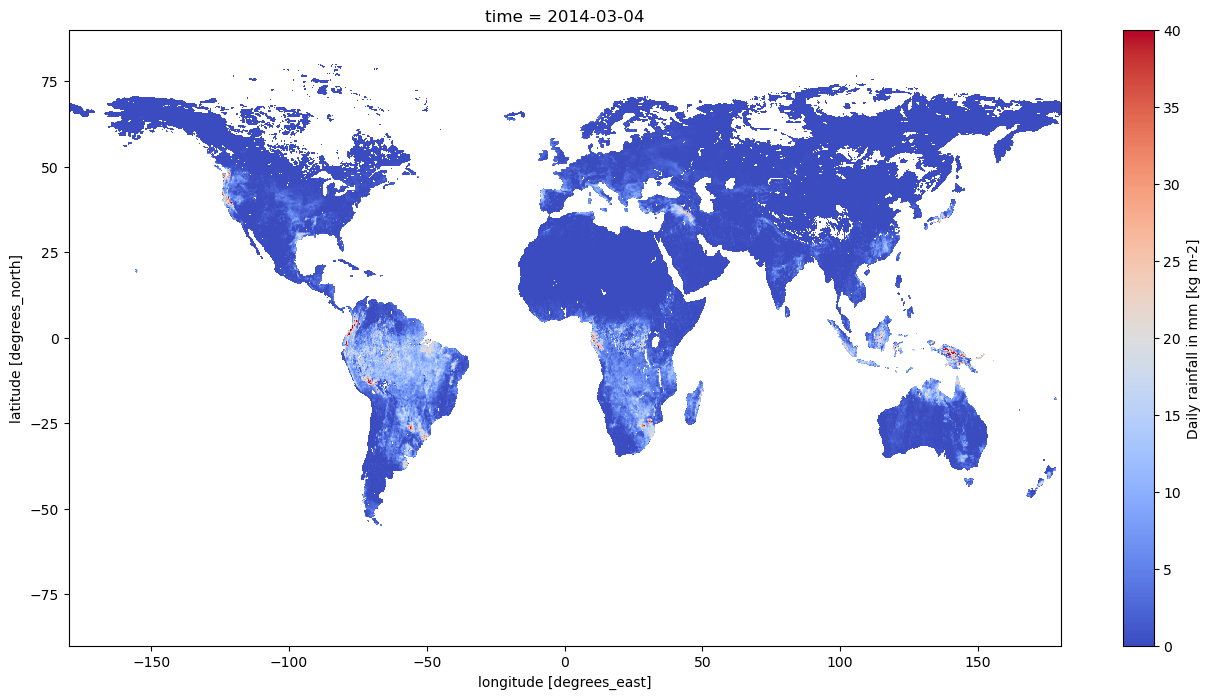

In [69]:
time_slice = 2620 
# number can be adapted to display a different timestamp, the first year goes from 0 to 365, then the second year starts at 366 and so on
plot = dataset.rainfall.isel(time=time_slice).plot.imshow(cmap='coolwarm')

# Adjust the range of the legend
min_value = 0  # desired minimum value
max_value = 40  # desired maximum value
plot.set_clim(vmin=min_value, vmax=max_value)